We will be taking a brief look at clustering and classification in this session:-

In [125]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
yf.pdr_override()

# Classification:-

You all might be familiar with logistic regression.<br>

Lets see a simple example to predict whether a stock price will go up or down using logistic regression

We will be working with S&P 500 data:-

In [357]:
data = yf.download('^GSPC',start = '2015-01-01', end = '2020-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In this example, we want to predict stock going up or down using previous days return

In [363]:
returns = pd.DataFrame(data['Close'].pct_change()).rename(columns = {'Close':'lag0_return'})
returns = returns.reset_index()
returns['lag1_return'] = returns['lag0_return'].shift(1)
returns['lag2_return'] = returns['lag0_return'].shift(2)
returns

,Date,lag0_return,lag1_return,lag2_return
0,2015-01-02,NaN,NaN,NaN
1,2015-01-05,-0.018278,NaN,NaN
2,2015-01-06,-0.008893,-0.018278,NaN
3,2015-01-07,0.011630,-0.008893,-0.018278
4,2015-01-08,0.017888,0.011630,-0.008893
...,...,...,...,...
1253,2019-12-24,-0.000195,0.000866,0.004945
1254,2019-12-26,0.005128,-0.000195,0.000866
1255,2019-12-27,0.000034,0.005128,-0.000195
1256,2019-12-30,-0.005781,0.000034,0.005128


In [369]:
returns = returns.dropna().reset_index(drop = True) #dropping null values
returns['direction'] = [1 if i>0 else 0 for i in returns['lag0_return']]
returns.head()

,Date,lag0_return,lag1_return,lag2_return,direction
0,2015-01-07,0.011630,-0.008893,-0.018278,1
1,2015-01-08,0.017888,0.011630,-0.008893,1
2,2015-01-09,-0.008404,0.017888,0.011630,0
3,2015-01-12,-0.008094,-0.008404,0.017888,0
4,2015-01-13,-0.002579,-0.008094,-0.008404,0


In [370]:
X = returns[['lag1_return','lag2_return']] #features
Y = returns['direction']

split = int(0.8*len(returns)) #train-test-split
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:] 

In [371]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [372]:
model = LogisticRegression()
model = model.fit(X_train,Y_train) #training_model

In [374]:
pd.DataFrame(list(zip(X_train.columns, np.transpose(model.coef_)))) #model coefficients

,0,1
0,lag1_return,[-0.21950792523417756]
1,lag2_return,[-0.0630414962756872]


In [378]:
predictions = model.predict(X_test)
print(metrics.classification_report(Y_test.values, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.59      1.00      0.75       149

    accuracy                           0.59       251
   macro avg       0.30      0.50      0.37       251
weighted avg       0.35      0.59      0.44       251



In [384]:
print(model.score(X_test,Y_test))

0.5936254980079682


We can see that model is performing better than a random chance( having accuracy greater than 50 percent ). It is decent but it can be improved as well by feature engineering. Feel free to experiment with features later to improve logistic regression model

You can add technical indicators such as momentum, MACD, moving averages as features as well..which will make the model richer

# Clustering

Clustering is a branch of unsupervised machine learning where the goal is to identify groups or clusters in your data set without the use of labels. In clustering, you are identifying a set of similar data points and calling the resulting set a cluster.

Let's consider an example of clustering. You may have a data set characterizing your customers like demographic information and personal preferences. A supervised machine learning application would be to determine whether a person will buy a product. However, an unsupervised machine learning application would be to identify several groups or types of customers. With these groups identified, you can analyze the groups and build profiles describing the groups.

In this notebook, we will discuss clustering metrics and K-means clustering algorithm, which I guess most of you might be familiar with.

We will apply K-means clustering to construct a portfolio of stocks for investing( **This is just an application of algorithm, not an investing recommendation**)

Two common metrics for clustering are

**Inertia**: the within cluster sum of square distance <br>
**Silhouette Coefficient**: a measure of how dense and separated are the clusters


$\sum_{𝑘}\sum_{X_{j}\in C_{k}}‖𝑋_{j}−𝜇_{k}‖^2$
 
where  $𝜇_{𝑘}$  is the centroid of cluster  𝑘  and  $𝐶_{𝑘}$  is the set of points assigned to cluster  𝑘 . Basically, the inertia is the sum of the distance of each point to the centroid or center of its assigned cluster. A lower inertia means the points assigned to the clusters are closer to the centroid.

The silhouette coefficient is a property assigned to each data point. It is equal to $\frac{𝑏−𝑎}{max(𝑎,𝑏)}$
 
where  𝑎  is the distance between a point and centroid of its assigned cluster and  𝑏  is the distance between the point and the centroid of the nearest neighboring cluster (i.e. the closest cluster the point is not assigned to). 

The silhouette coefficient ranges from -1 to 1. Maximizing the silhouette coefficient will prioritize dense and highly separated clusters as dense clusters will have a low  𝑎  value and having clusters well separated from each other will increase  𝑏 .

# K - Means Clustering Application

The $𝐾$-means algorithms seeks to find $𝐾$ clusters within a data set. The clusters are chosen to reduce the inertia<br>

The training algorithm for $𝐾$-means is straight-forward. After seeding the algorithm, choosing the starting locations of each cluster's centroid,

1) Assign each point to a cluster based on which cluster centroid it's the closest to <br>
2) Calculate the centroid of resulting cluster using the points that have been assigned to the cluster <br>
3) Repeat the above steps until convergence is met <br>


**Lets look at an application of K-means to stock market:-**<br>
    
I want to start investing in stock market, and I have no knowledge of it currently. Since there are so many stocks avaialble, I want to construct a portfolio of stocks which can givc me good returns or which are performing well. 

Let us download the stock data of companies listed in S&P 500, and then use that to filter our stocks:-

In [255]:
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies' 
html_file = pd.read_html(sp500_url)
html_file[0].head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [256]:
company_symbols = html_file[0]['Symbol']
company_names = html_file[0]['Security']

company_dict = dict(zip(company_symbols,company_names))

Now I want to download the stock price data of all these companies from yahoo finance. To feed it into the API, I need to join them in the form of a string which we will take a look at below:-

In [257]:
company_string = ' '.join([company for company in list(company_symbols)])
stocks_data = pdr.get_data_yahoo(company_string, start='2019-01-01', end='2020-01-01')['Close']
stocks_data.head()

[*********************100%***********************]  505 of 505 completed

5 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CARR: Data doesn't exist for startDate = 1546318800, endDate = 1577854800
- BRK.B: No data found, symbol may be delisted
- OTIS: Data doesn't exist for startDate = 1546318800, endDate = 1577854800
- OGN: Data doesn't exist for startDate = 1546318800, endDate = 1577854800


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,65.690002,32.480000,157.919998,39.480000,89.230003,74.449997,309.959991,69.500000,140.589996,224.570007,...,48.220001,86.849998,69.690002,37.889999,66.510002,91.440002,102.279999,156.240005,41.580002,84.480003
2019-01-03,63.270000,30.059999,162.850006,35.547501,86.290001,73.370003,302.290009,66.220001,135.789993,215.699997,...,48.029999,83.580002,68.620003,37.910000,64.230003,89.139999,100.430000,146.880005,41.349998,81.559998
2019-01-04,65.459999,32.040001,158.809998,37.064999,89.070000,74.220001,313.440002,68.110001,141.070007,226.190002,...,48.500000,87.449997,71.150002,39.009998,66.940002,91.459999,103.860001,152.970001,42.619999,84.760002
2019-01-07,66.849998,32.950001,161.139999,36.982498,90.370003,74.750000,314.799988,69.129997,141.559998,229.259995,...,48.290001,89.760002,71.519997,39.709999,65.949997,91.360001,103.900002,155.289993,42.790001,85.269997
2019-01-08,67.830002,32.419998,160.020004,37.687500,90.790001,75.550003,318.420013,68.300003,145.139999,232.679993,...,48.849998,88.050003,72.040001,39.439999,66.570000,91.180000,101.570000,156.330002,43.180000,86.540001


In [259]:
trading_days = len(stocks_data) #calculating number of trading days in a year
trading_days

252

I want to decide my portfolio of stocks based on yearly return and yearly volatility.<br>

For that I will need to calculate yearly return and yearly volatility for each of the companies:- <br>

Let $r_1$, $r_2$, $\ldots$, $r_{252}$ be the the daily returns of the stock in a trading year and $r_0$ be the yearly return. Then we can write:-
    
$1+r_{0} = (1+r_{1})(1+r_{2})\ldots(1+r_{252})$ <br>

An Approximate way of calculating yearly return and yearly variance is as follows:-

$\ln(1+r_{0}) = \sum_{i=1}^{i=252}\ln(1+r_{i})$

$\ln(1+x)$ can be approximated as x when x is small.

$r_{0} = \sum_{i=1}^{i=252}r_{i} = Mean Return * Trading Days$


In [309]:
stock_stats = pd.DataFrame(stocks_data.pct_change().mean()*trading_days) #yearly return for each of the stocks
stock_stats.columns = ['Yearly_return']
stock_stats['Yearly_Volatility'] = stocks_data.pct_change().std() * math.sqrt(trading_days) #yearly volatality calculation
stock_stats = stock_stats.dropna() #removing null values
stock_stats
#returns.drop('TSLA', inplace = True)

,Yearly_return,Yearly_Volatility
A,0.292525,0.243389
AAL,-0.061518,0.355943
AAP,0.049455,0.265625
AAPL,0.658108,0.262326
ABBV,0.031054,0.273103
...,...,...
YUM,0.109296,0.155753
ZBH,0.406194,0.218767
ZBRA,0.565628,0.380701
ZION,0.255231,0.253621


Now we can get started with clustering. The main thing is choosing the right value of $k$, as it is a hyperparameter

We expect as we use more clusters to group our observations the inertia goes down because the points will be closer to the cluster's centroid.  

we need to identify at what point is increasing the number of clusters no longer resulting in an appreciable drop in inertia (the point of diminishing returns). We do that by using ELBOW method:-

The below function experiments with a few values of K and plots the inertia and silhouette score:-

In [312]:
def plot_cluster(X, max_loop=20):
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10)
        kmeans.fit(X)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

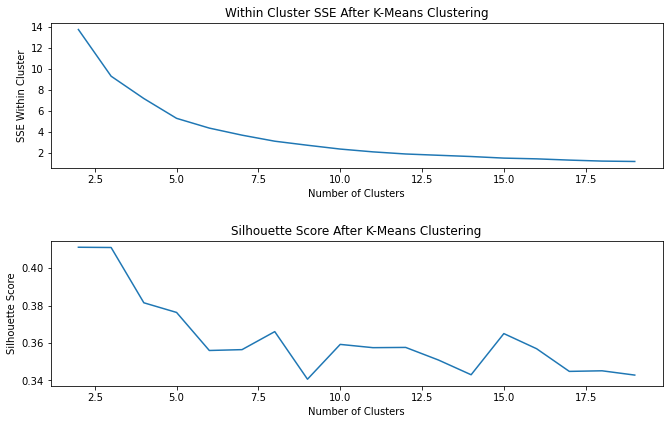

In [313]:
plot_cluster(stock_stats.values)

We see that in first plot, at $k=8$ there is a kink, and when we go from $k=8$ to $k=9$, the Silhouette Score drops massively as well. Hence, we will go ahead with $k=8$

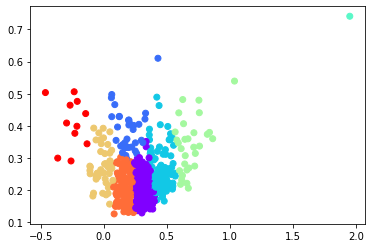

In [314]:
features = stock_stats.values
kmeans = KMeans(n_clusters = 8).fit(features)
centroids = kmeans.cluster_centers_
plt.scatter(features[:,0],features[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

We can see in the above plot that there is one outlier point towards the extreme right. We should remove that as that is redundant. It is the point with max value of yearly return and yearly volatlity

In [315]:
stock_stats.idxmax()

Yearly_return        ENPH
Yearly_Volatility    ENPH
dtype: object

In [316]:
stock_stats.drop('ENPH', inplace = True)
stock_stats.shape

(499, 2)

Now, lets run again our k-means function on the updated data

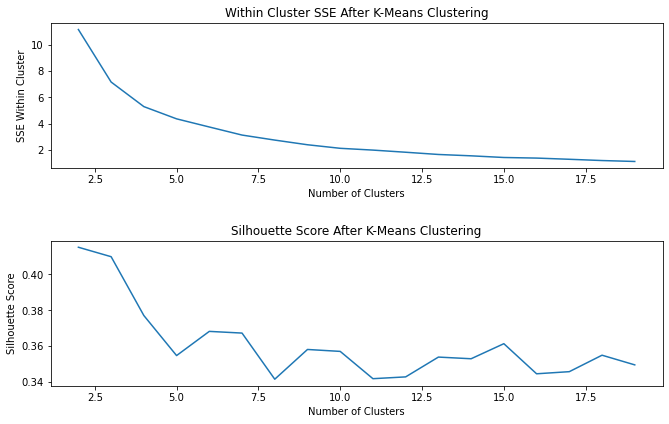

In [317]:
plot_cluster(stock_stats)

Now we can see after removal of outlier point, the value of $k$ being observed is 6

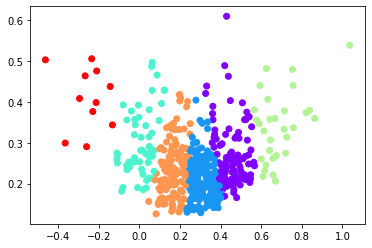

In [318]:
features = stock_stats.values
kmeans = KMeans(n_clusters = 6).fit(features)
centroids = kmeans.cluster_centers_
plt.scatter(features[:,0],features[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

In [319]:
stock_stats['cluster_labels'] = kmeans.labels_
stock_stats.head()

,Yearly_return,Yearly_Volatility,cluster_labels
A,0.292525,0.243389,1
AAL,-0.061518,0.355943,2
AAP,0.049455,0.265625,2
AAPL,0.658108,0.262326,3
ABBV,0.031054,0.273103,2


In [320]:
stock_stats['cluster_labels'].value_counts()

1    173
4    129
0    101
2     55
3     30
5     11
Name: cluster_labels, dtype: int64

In [321]:
stock_stats_with_symbols = stock_stats.reset_index().rename(columns = {'index':'Symbol'})

Now I want to understand for each cluster, the mean yearly return and mean yearly volatality:-

In [322]:
stock_clustered = (
     stock_stats_with_symbols
    .groupby('cluster_labels')
    .agg({"Yearly_return":"mean", "Yearly_Volatility":"mean", "Symbol":"size"})
    .rename(columns = {"Symbol":"Count"})
    .reset_index()
)

stock_clustered

,cluster_labels,Yearly_return,Yearly_Volatility,Count
0,0,0.453818,0.269756,101
1,1,0.309798,0.211576,173
2,2,0.009995,0.298502,55
3,3,0.686895,0.338960,30
4,4,0.169479,0.234467,129
5,5,-0.255456,0.409605,11


Now, clusters 2 and 5 are not useful to us since they have very low return along with high volatality. 

Since, cluster 1 has lot of stocks in it, its worth examining a bit more. Let us try to run K-means again on that, to see if we can get a pool of better performing stocks:-

In [351]:
stock_stats_sub_symbols = stock_stats_with_symbols[stock_stats_with_symbols['cluster_labels'] == 1].reset_index(drop=True)
stock_stats_sub = stock_stats[stock_stats['cluster_labels'] == 1].reset_index(drop=True)

In [346]:
stock_stats_sub.iloc[:,0:2] #this will be the feature passed to k-means

,Yearly_return,Yearly_Volatility
0,0.292525,0.243389
1,0.243146,0.195846
2,0.287912,0.182200
3,0.269393,0.135657
4,0.360297,0.199490
...,...,...
168,0.252919,0.144249
169,0.373861,0.165771
170,0.364671,0.223062
171,0.286342,0.141609


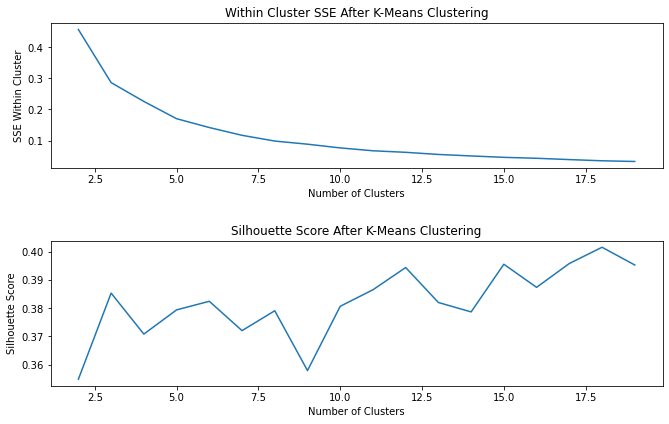

In [352]:
plot_cluster(stock_stats_sub.iloc[:,0:2].values)

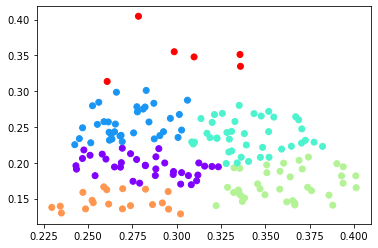

In [353]:
Y = stock_stats_sub.iloc[:,0:2].values
kmeans = KMeans(n_clusters = 6).fit(Y)
centroids = kmeans.cluster_centers_
plt.scatter(Y[:,0],Y[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

In [354]:
agg_df3_sub_symbols['cluster_labels'] = kmeans.labels_
agg_df3_sub_symbols


,Symbol,Yearly_return,Yearly_Volatility,cluster_labels
0,A,0.292525,0.243389,1
1,ABT,0.243146,0.195846,0
2,ADP,0.287912,0.182200,0
3,AEP,0.269393,0.135657,4
4,AES,0.360297,0.199490,3
...,...,...,...,...
168,WMT,0.252919,0.144249,4
169,WRB,0.373861,0.165771,3
170,WY,0.364671,0.223062,2
171,XEL,0.286342,0.141609,4


In [355]:
stock_sub_clustered = (
    agg_df3_sub_symbols
    .groupby('cluster_labels')
    .agg({"Yearly_return":"mean", "Yearly_Volatility":"mean", "Symbol":"size"})
    .rename(columns = {'Symbol':'Count'})
    .reset_index()
)

stock_sub_clustered

,cluster_labels,Yearly_return,Yearly_Volatility,Count
0,0,0.282965,0.194491,35
1,1,0.272825,0.254668,35
2,2,0.340325,0.237069,41
3,3,0.360087,0.169713,37
4,4,0.265619,0.146097,19
5,5,0.303187,0.351161,6


Now we can see, in cluster number 3, we have a pool of stocks with 36 percent return and 17 percent volatility, which gives us a good starting point to begin with. We can further research on these stocks and then make a call

There are metrics like **sharpe ratio** which are used to assess the risk-return profile of a stock, which we will take a look at in subsequent lab sessions:-

For now, we have identified a set of stocks for out portfolio. You can print their company names as an exercise

**The method which I illustrated above shows how k-means can be applied to arrive at portfolio of stocks. Its just an example. There are draw backs of K-means as well**